In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [2]:
input_size  = 28*28   # imagens com 28x28 pixels
output_size = 10      # 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

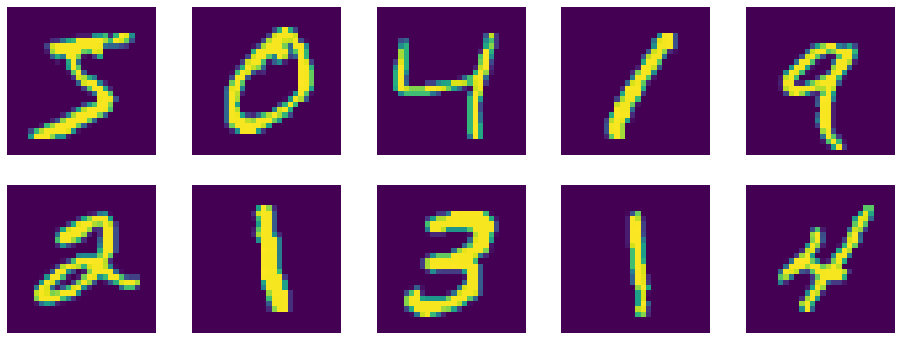

In [3]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [16]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ELU(),
            nn.Linear(n_hidden, n_hidden-10), 
            nn.ELU(),
            nn.Linear(n_hidden-10, n_hidden-10), 
            nn.ELU(),
            nn.Linear(n_hidden-10, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, n_feature):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.elu(x)                
        x = F.max_pool2d(x, kernel_size=2)        
        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.elu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
accuracy_list = []

# Função para retornar o número de parâmetros de um modelo
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def train(epoch, model):
    # Coloca o modelo em modo de treinamento
    model.train()
    
    # Loop sobre os mini-batches, fornecidos pelo DataLoader train_loader
    for batch_idx, (data, target) in enumerate(train_loader):      
        # Para mandar os dados para o device (GPU ou CPU definido anteriormente), usamos o método .to(device)
        data, target = data.to(device), target.to(device)
        
        # Ajuste de dimensões
        data = data.view(-1, 1, 28, 28)

        # Necessário no PyTorch, para limpar o cache de gradientes acumulados
        optimizer.zero_grad()
        
        # Cálculo da saída
        output = model(data)
        
        # nll_loss é a função custo da entropia cruzada
        loss = F.cross_entropy(output, target)
        
        # cálculo dos gradientes
        loss.backward()
        
        # atualização dos parâmetros do modelo
        optimizer.step()
        
        # Exibe o status do treinamento
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    # Coloca o modelo em modo de teste
    model.eval()
    
    # Variáveis usadas para contabilizar o valor da função custo e número de acertos
    test_loss = 0
    correct = 0
    
    # Loop sobre os mini-batches, fornecidos pelo DataLoader test_loader
    for data, target in test_loader:
        
        # Para mandar os dados para o device (GPU ou CPU definido anteriormente), usamos o método .to(device)     
        data, target = data.to(device), target.to(device)
        
        # Ajuste de dimensões
        data = data.view(-1, 1, 28, 28)
        
        # Cálculo da saída
        output = model(data)

        # Valor da função custo
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss                                                               

        # Cálculo do número de acertos
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    # Mostra o desempenho obtido no teste    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [22]:
# número de neurônios da camada oculta
n_hidden = 28

# Instanciando o modelo
model_fnn = MLP(input_size, n_hidden, output_size)

# Para mandar o modelo para o device (GPU ou CPU definido anteriormente), usamos o método .to(device)     
model_fnn.to(device)

# Definição do otimizador a ser utilizado. Aqui é usado o SGD, que usa o gradiente descendente com momentum
#optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.AdamW(model_fnn.parameters() , betas=(0.9, 0.99), lr=0.01)

# Mostra o número de parâmetros do modelo
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

# Loop das épocas de treinamento. Aqui é usada apenas 1 época.
for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 23034
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.363359
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.389773
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.280491
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.217398
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.130932
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.364420
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.248044
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.226235
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.321682
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.184496

Test set: Average loss: 0.1783, Accuracy: 9474/10000 (95%)



In [20]:
# Número de filtros das camadas convolucionais
n_features = 10

# Instanciando o modelo
model_cnn = CNN(n_features)

# Para mandar o modelo para o device (GPU ou CPU definido anteriormente), usamos o método .to(device)     
model_cnn.to(device)

# Definição do otimizador a ser utilizado. Aqui é usado o SGD, que usa o gradiente descendente com momentum
#optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.AdamW(model_cnn.parameters() , betas=(0.9, 0.95), lr=0.001)

# Mostra o número de parâmetros do modelo
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

# Loop das épocas de treinamento. Aqui é usada apenas 1 época.
for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 11330
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.351154
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.294858
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.216681
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.197638
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.159050
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.086734
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.070098
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.197826
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.067905
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.104552

Test set: Average loss: 0.0691, Accuracy: 9781/10000 (98%)

